In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from collections import Counter
from numba import jit, prange

In [2]:
def tent_map(x: np.ndarray, r: float) -> np.ndarray:
    return np.where(x <= 0.5, r * x, r * (1 - x))

def fprime(x: np.ndarray, r: float) -> np.ndarray:
    return np.where(x <= 0.5, r, -r)

def lyaunov_exponent(x: np.ndarray, r: float, n: int) -> np.ndarray:
    x = tent_map(np.repeat(x, n), r)
    return np.sum(np.log(np.abs(fprime(x, r)))) / n

def bifurcation_diagram(a_values, iterations):
    results = []
    x = 0.5 * np.ones_like(a_values)  # Initial condition for all parameter values
    for _ in range(iterations):
        x = tent_map(x, a_values)
        results.extend(list(zip(a_values, x)))
    return results


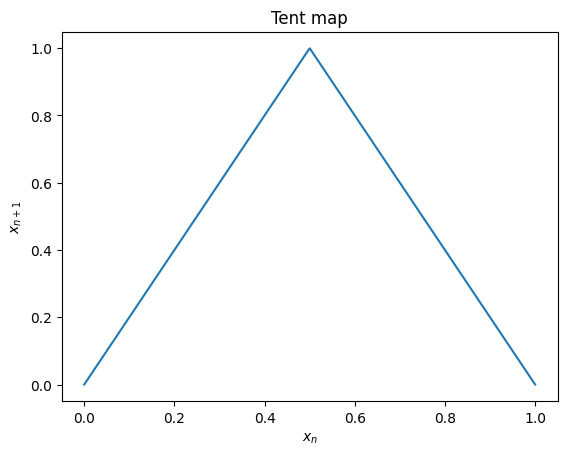

In [3]:
N = 1000

r = np.linspace(0, 2, N)
x = np.linspace(0, 1, N)
xn = np.zeros(N)

for i in range(1,N):
    for j in range(N):
        xn[j] = tent_map(x[j], r[i])


plt.plot(x, xn)
plt.xlabel('$x_n$')
plt.ylabel('$x_{n+1}$')
plt.title('Tent map')
plt.show()

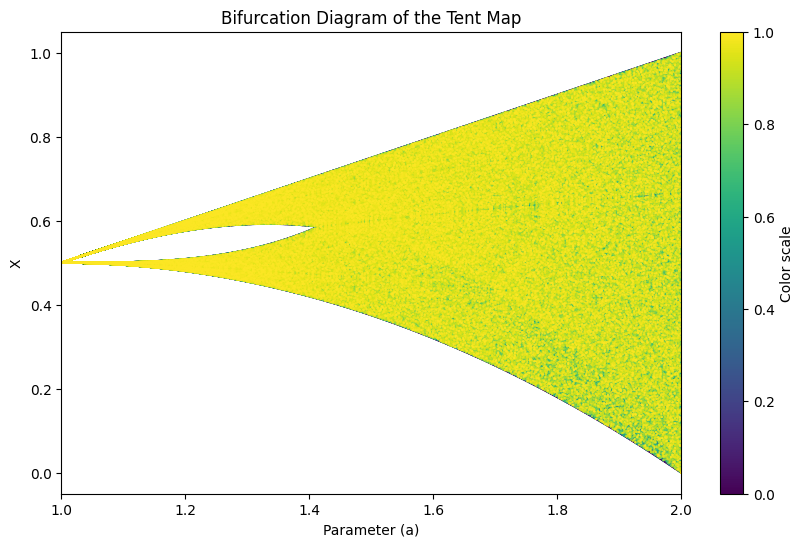

In [4]:
r = np.linspace(1, 2, N)  # Generate N values between 1 and 2
bifurcation_data = bifurcation_diagram(r, N)

# Create a color array
colors = np.linspace(0, 1, len(bifurcation_data))

# Plot the bifurcation diagram
plt.figure(figsize=(10, 6))
plt.scatter(*zip(*bifurcation_data), s=1, marker='.', c=colors, cmap=plt.cm.viridis)
plt.title('Bifurcation Diagram of the Tent Map')
plt.xlabel('Parameter (a)')
plt.ylabel('X')
plt.xlim(1, 2)  # Set the x-axis limits from 0 to 1
plt.colorbar(label='Color scale')  # Add a colorbar
plt.show()

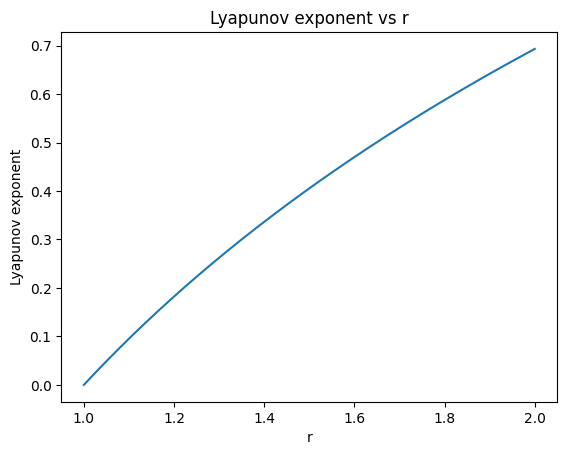

In [5]:
# plotting the Lyapunov exponent vs r
lyapunov = np.array([lyaunov_exponent(0.5, r, N) for r in np.linspace(1, 2, N)])

plt.plot(np.linspace(1, 2, N), lyapunov)
plt.xlabel('r')
plt.ylabel('Lyapunov exponent')
plt.title('Lyapunov exponent vs r')
plt.show() 

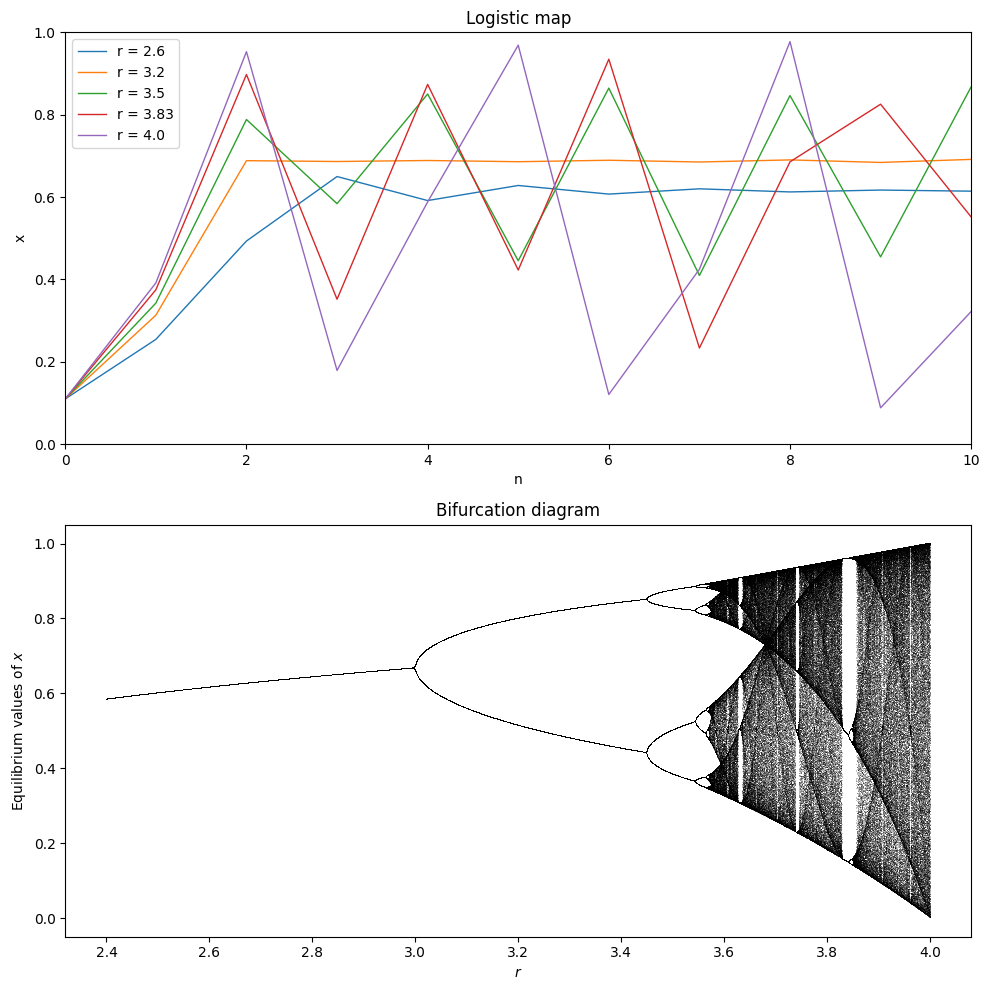

In [6]:
def logistic_map(x: float, r: float) -> float:
    """The logistic map function."""
    return r * x * (1 - x)

def logistic_map_iterate(x: np.ndarray, r: float, N: int) -> np.ndarray:
    """Iterates the logistic map N times."""
    for i in range(N):
        x[i + 1] = logistic_map(x[i], r)
    return x

def plot_logistic_map(ax: plt.Axes, x: np.ndarray, r_series: list, N: int)-> None:
    """Plots the logistic map for different r values."""
    for r in r_series:
        x = logistic_map_iterate(x, r, N)
        ax.plot(x, linewidth=1, label=f'r = {r}')
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 1])
    ax.set_xlabel('n')
    ax.set_ylabel('x')
    ax.set_title('Logistic map')
    ax.legend()

def plot_bifurcation_diagram(ax: plt.Axes, x: np.ndarray, r_vals: np.ndarray, N: int, N_skip: int) -> None:
    """Plots the bifurcation diagram."""
    for i in range(N):
        x = logistic_map(x, r_vals)
        if i >= N_skip:
            ax.plot(r_vals, x, ',k', alpha=0.25)
    ax.set_xlabel('$r$')
    ax.set_ylabel('Equilibrium values of $x$')
    ax.set_title('Bifurcation diagram')

N = 1000
N_skip = int(2 * N / 3)
r_series = [2.6, 3.2, 3.5, 3.83, 4.0]
r_vals = np.linspace(2.4, 4.0, 4000)

x = np.zeros(N + 1)
x[0] = 0.11

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot logistic map for different r values
plot_logistic_map(axs[0], x, r_series, N)

# Plot bifurcation diagram
plot_bifurcation_diagram(axs[1], 0.5 * np.ones_like(r_vals), r_vals, N, N_skip)

plt.tight_layout()
plt.show()

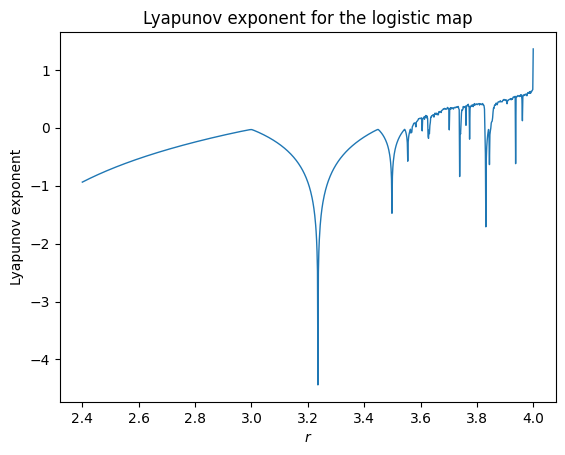

In [7]:
def logistic_map_deriv(x: float, r: float) -> float:
    return r - 2 * r * x

def compute_lyapunov(r: float, x0: float, N: int) -> float:
    x = x0
    lyapunov = 0
    for i in range(N):
        lyapunov += np.log(abs(logistic_map_deriv(x, r)) + 1e-10)
        x = logistic_map(x, r)
    return lyapunov / N

r_vals = np.linspace(2.4, 4.0, N)
x0 = 0.5
lyapunov_exponents = np.zeros(r_vals.shape)

for i, r in enumerate(r_vals):
    lyapunov_exponents[i] = compute_lyapunov(r, x0, N)

# set line width to 1
plt.plot(r_vals, lyapunov_exponents, lw=1)
plt.xlabel('$r$')
plt.ylabel('Lyapunov exponent')
plt.title('Lyapunov exponent for the logistic map')
plt.show()

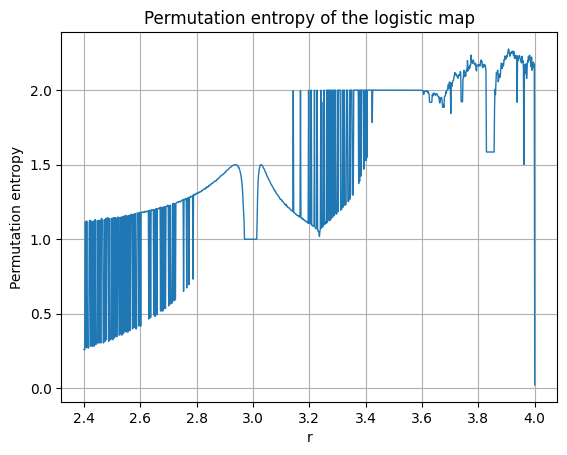

In [12]:
@jit(nopython=True)
def logistic_map(x, r):
    return r * x * (1 - x)

@jit(nopython=True)
def generate_logistic_map(N, r, x0=0.5):
    x = np.empty(N)
    x[0] = x0
    for i in range(N-1):
        x[i+1] = logistic_map(x[i], r)
    return x

def permutation_entropy(time_series, m, delay):
    n = len(time_series)
    permutations = (str(np.argsort(time_series[i:i+m*delay:delay])) for i in range(n-m*delay+1))
    c = list(Counter(permutations).values())
    c = np.array(c) / float(sum(c))
    pe = -np.sum(c*np.log2(c))
    return pe

N = 1000
r_values = np.linspace(2.4, 4.0, N)
pe_values = np.zeros_like(r_values)

for i in prange(r_values.shape[0]):
    x = generate_logistic_map(N, r_values[i])
    pe_values[i] = permutation_entropy(x, m=3, delay=1)

plt.plot(r_values, pe_values, lw=1)
plt.xlabel('r')
plt.ylabel('Permutation entropy')
plt.title('Permutation entropy of the logistic map')
plt.grid(True)
plt.show()

In [9]:
def fisher_information(time_series: np.ndarray, epsilon: float = 1e-5) -> float:
    n = len(time_series)
    p = np.histogram(time_series, bins='auto', density=True)[0]  # Calculate probability density
    p = p[p > 0]  # Remove zero probabilities
    fim = np.sum((np.gradient(np.log(p + epsilon)))**2 / p)  # Calculate FIM
    return fim

N = 1000
r = 3.9
x = np.zeros(N)
x[0] = 0.5

# Generate the logistic map
for i in range(N-1):
    x[i+1] = logistic_map(x[i], r)

# Calculate the Fisher Information Measure
fim = fisher_information(x)
print(f'Fisher Information Measure: {fim}')

Fisher Information Measure: 1.8583645342327149
